# Module 1 - Classification
This notebook explores how early machine learning models can classify text as poetic or legal based on word patterns.

We use:

* Poetic text from selected Shakespeare sonnets

* Legal text from the U.S. Constitution (Articles I and II)

Each sentence is labeled (0 = poetic, 1 = legal), and converted to numbers using a Bag-of-Words approach — counting how often each word appears.

We demonstrate three models:

* Perceptron (classic, mistake-driven) manually implemented and using existing package

* Logistic Regression (probabilistic, weight-based)

* Naive Bayes (probabilistic, frequency-based)

These models show how early AI learned to classify text — without understanding meaning.

## Install and import Packages

In [ ]:
#@title Install required packages {display-mode: "form"}
!pip install numpy matplotlib pandas scikit-learn

In [63]:
#@title import required packages {display-mode: "form"}
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Load and process data
* we first read the data from 01_perceptron_logreg/data/labeled_sentences.csv
* In this file, we have shuffled sentences from 10 arbitraily picked sonnets by Shakespear, and Article I of the US Constitution. When the sentence is from the sonnets (hence "poetic"), it is labeled as 0. Otherwise it is labeled as 1.
* With this data set, we can train some simple models to identify whether a sentence is in a more poetic tone or a more legal tone.

In [ ]:
# load data from the GitHub repo of the Demo
url_header = "https://raw.githubusercontent.com/WeihaoGe1009/ml-demos-temp-inputs/main/"
module_name = "01_perceptron_logreg/"
data_dir = url_header+module_name+'data/'
input_file = data_dir + 'labeled_sentences.csv'
df_data = pd.read_csv(input_file)

In [ ]:
# show 5 lines of the input data
df_data.head(5)

,Sentence,Label
0,"Pity the world, or else this glutton be—",0
1,"If snow be white, why then her breasts are dun;",0
2,"The Times, Places and Manner of holding Electi...",1
3,"For fear of which, hear this, thou age unbred:",0
4,"So, till the judgment that yourself arise,",0


### Train-test split
it is important to split the input data into a training set and a test set (in some references, you can see there is a validation set as well). We train our models based on the training set. But since the model's parameters are calculated from the data in the training set, it would achieve very high accuracy using the same data. Therefore, we set aside some data before training, so that we can evaluate the model performance more objectively.

In [11]:
# train-test split
train_df, test_df = train_test_split(df_data, test_size=0.2, stratify=df_data['Label'], random_state=42)

### Vectorization - converint text to numbers
Computers do not "see" letters, they only deal with numbers. Therefore, we have to convert text to numbers. Here, we would use a very simple way: replacing the word by their counts in the sample. The frequencies of the words already carry some information.

In [12]:
# First, we split sentences into words
def tokenize(text):
    return text.lower().split()  # basic word-by-word splitting

# Then, we build the vocabulary from the training data only
# This is our list of known words — like the dictionary the model can learn from
vocab = sorted(set(word for sentence in train_df['Sentence'] for word in tokenize(sentence)))
word_to_index = {word: i for i, word in enumerate(vocab)}

# then we use an algorithm called "Bag of Words",
# which encodes each word by how many time it appears
# Each sentence becomes a list of numbers — how often each word appears
def sentence_to_vector(sentence):
    vector = np.zeros(len(vocab))
    for word in tokenize(sentence):
        if word in word_to_index:
            vector[word_to_index[word]] += 1
    return vector

# Now we convert all training and test sentences into vectors
X_train = np.array([sentence_to_vector(s) for s in train_df['Sentence']])
y_train = train_df['Label'].values  # 0 = poetic, 1 = legal

X_test = np.array([sentence_to_vector(s) for s in test_df['Sentence']])
y_test = test_df['Label'].values

## manual implementation of Perceptron
Perceptron is a very early AI model. Here we are going to train a Perceptron to distinguish between poetic and legal sentences. First, we turned each sentence into a list of word counts (Bag-of-Words). Then the model practiced by reading examples and adjusting whenever it guessed wrong. Finally, we tested the model on new sentences to see how well it learned.

In [16]:
# manual implementation of perceptron
# Convert labels to Perceptron-friendly format: -1 and +1

y_train_bin = np.where(y_train == 0, -1, 1)

# Initialize a blank model (Perceptron)
weights = np.zeros(len(vocab))  # One value (or "dial") per word
bias = 0                        # Extra offset
learning_rate = 1.0
epochs = 10
min_mistakes = 2  # Stop training early if fewer than 2 mistakes.

In [17]:
# Training — the model practices reading
for round in range(epochs):
    print(f"Round {round + 1}")
    mistakes = 0
    for i in range(len(X_train)):
        result = np.dot(weights, X_train[i]) + bias

        # If the model makes a mistake, adjust its understanding
        if y_train_bin[i] * result <= 0:
            weights += learning_rate * y_train_bin[i] * X_train[i]
            bias += learning_rate * y_train_bin[i]
            mistakes += 1
            print(f"  Incorrect on sentence {i}, updating model.")

    print(f"  Total mistakes this round: {mistakes}\n")

    # Early stopping condition
    if mistakes < min_mistakes:
        print(f"Stopping early — only {mistakes} mistakes this round.")
        break

Round 1
  Incorrect on sentence 0, updating model.
  Incorrect on sentence 1, updating model.
  Incorrect on sentence 3, updating model.
  Incorrect on sentence 6, updating model.
  Incorrect on sentence 8, updating model.
  Incorrect on sentence 11, updating model.
  Incorrect on sentence 17, updating model.
  Incorrect on sentence 21, updating model.
  Incorrect on sentence 22, updating model.
  Incorrect on sentence 29, updating model.
  Incorrect on sentence 42, updating model.
  Incorrect on sentence 56, updating model.
  Incorrect on sentence 72, updating model.
  Incorrect on sentence 104, updating model.
  Incorrect on sentence 108, updating model.
  Incorrect on sentence 120, updating model.
  Incorrect on sentence 126, updating model.
  Incorrect on sentence 136, updating model.
  Incorrect on sentence 138, updating model.
  Total mistakes this round: 19

Round 2
  Incorrect on sentence 17, updating model.
  Incorrect on sentence 99, updating model.
  Total mistakes this roun

In [18]:
# Use the trained model to predict legal vs poetic on the test set
def predict(X_input):
    result = np.dot(X_input, weights) + bias
    return np.where(result > 0, 1, 0)  # 1 = legal, 0 = poetic

# Evaluate how well the model did
y_pred = predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Test accuracy: {accuracy:.2f}")

Test accuracy: 0.97


In [19]:
# Show a few prediction examples to the user
print("\nSample Predictions:")
num_examples = 5  # Show 5 test cases
for i in range(num_examples):
    sentence = test_df['Sentence'].iloc[i]
    true_label = "Legal" if y_test[i] == 1 else "Poetic"
    predicted_label = "Legal" if y_pred[i] == 1 else "Poetic"

    print(f"\nSentence {i+1}:")
    print(f"  Text: \"{sentence}\"")
    print(f"  True label: {true_label}")
    print(f"  Predicted:  {predicted_label}")


Sample Predictions:

Sentence 1:
  Text: "No Title of Nobility shall be granted by the United States: And no Person holding any Office of Profit or Trust under them, shall, without the Consent of the Congress, accept of any present, Emolument, Office, or Title, of any kind whatever, from any King, Prince, or foreign State."
  True label: Legal
  Predicted:  Legal

Sentence 2:
  Text: "Past reason hated as a swallowed bait"
  True label: Poetic
  Predicted:  Poetic

Sentence 3:
  Text: "When in eternal lines to time thou grow’st."
  True label: Poetic
  Predicted:  Poetic

Sentence 4:
  Text: "Of this our time, all you prefiguring;"
  True label: Poetic
  Predicted:  Poetic

Sentence 5:
  Text: "To make Rules for the Government and Regulation of the land and naval Forces;"
  True label: Legal
  Predicted:  Legal


In [26]:
# Now: Try your own sentence!
# Change the sentence below to test what the model predicts
input_sentence = "This Constitution shall be the supreme Law of the Land."

# Convert it to a bag-of-words vector using the training vocabulary
input_vector = sentence_to_vector(input_sentence)

# Predict using the trained model
result = np.dot(weights, input_vector) + bias
predicted_label = "Legal" if result > 0 else "Poetic"

print("\nYour sentence:")
print(f"  \"{input_sentence}\"")
print(f"Predicted label: {predicted_label}")


Your sentence:
  "This Constitution shall be the supreme Law of the Land."
Predicted label: Legal


After training, we can ask the model to label new sentences it has never seen before, we compare it to the correct answer. This helps us see where the model is working well and where it might still be confused.

## Perceptron from package
* in real practice, it is not necessary to implement everything from beginning. We load packages which does the mathematics for us and optimized for the performance
* This version uses a built-in Perceptron from a well-known machine learning toolkit called scikit-learn. It handles all the weight updates and training process internally. We give it the same word-count data (Bag-of-Words) and let it learn how to tell poetic and legal sentences apart.

In [25]:
# Train the model using scikit-learn's Perceptron
clf = Perceptron(max_iter=10, tol=1e-3, random_state=42)
clf.fit(X_train, y_train)  # y_train stays as 0/1 — no need to convert to -1/1

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Scikit-learn Perceptron Test Accuracy: {accuracy:.2f}")

Scikit-learn Perceptron Test Accuracy: 0.97


In [27]:
# Now: Try your own sentence!
# Change the sentence below to test what the model predicts
input_sentence = "Shall I compare thee to a summer's day?"

# Convert it to a bag-of-words vector using the training vocabulary
input_vector = sentence_to_vector(input_sentence)

# Predict using the trained model
predicted_label = clf.predict([input_vector])[0]

# Show result
print("\nYour sentence:")
print(f"  \"{input_sentence}\"")
print("Predicted label:", "Legal" if predicted_label == 1 else "Poetic")


Your sentence:
  "Shall I compare thee to a summer's day?"
Predicted label: Poetic


## Logistic regression
Logistic Regression is a widely used classification model. It works by estimating the probability that a sentence belongs to a certain category (like legal or poetic), based on the words it contains. The model adjusts how important each word is during training and makes predictions by combining those learned weights.

In [46]:
# Train Logistic Regression model
log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train, y_train)  # Labels stay as 0 (poetic) and 1 (legal)

# Predict on the test set
log_y_pred = log_clf.predict(X_test)
log_accuracy = accuracy_score(y_test, log_y_pred)
print(f"Logistic Regression Test Accuracy: {log_accuracy:.2f}")

Logistic Regression Test Accuracy: 0.97


In [67]:
# Try your own sentence!
# Change the sentence below to test what the model predicts
input_sentence = "To make Rules for the Government and Regulation of the land and naval Forces;"

# Convert to Bag-of-Words vector
input_vector = sentence_to_vector(input_sentence)

# Predict probability
probs = log_clf.predict_proba([input_vector])[0]  # returns [prob_poetic, prob_legal]

# Predict label
predicted_label = log_clf.predict([input_vector])[0]

# Show result
print("\nYour sentence:")
print(f"  \"{input_sentence}\"")
print(f"Predicted probabilities: Poetic = {probs[0]:.2f}, Legal = {probs[1]:.2f}")
print("Predicted label:", "Legal" if predicted_label == 1 else "Poetic")


Your sentence:
  "To make Rules for the Government and Regulation of the land and naval Forces;"
Predicted probabilities: Poetic = 0.14, Legal = 0.86
Predicted label: Legal


#### How do logistic regression model "decide"?

Behind the scenes, Logistic Regression gives each word a weight based on how strongly it signals one category. In our case, positive weights push the sentence toward legal, and negative weights push toward poetic.

The model then adds up the weights for the words it sees and turns that into a probability for each category.


Your sentence:
  "All legislative powers shall be vested in a Congress of the United States."
Predicted probabilities: Poetic = 0.51, Legal = 0.49
Predicted label: Poetic


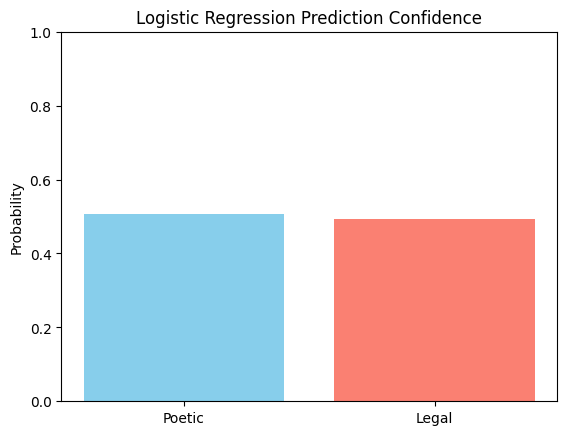


Top words in your sentence that influenced the prediction:
  all             → weight = -0.0274 → favors Poetic
  legislative     → weight = +0.0163 → favors Legal
  powers          → weight = +0.0177 → favors Legal
  shall           → weight = +0.9522 → favors Legal
  be              → weight = +0.6297 → favors Legal
  vested          → weight = +0.0177 → favors Legal
  in              → weight = -0.1303 → favors Poetic
  a               → weight = +0.5016 → favors Legal
  congress        → weight = +0.0454 → favors Legal
  of              → weight = +0.6194 → favors Legal
  the             → weight = +1.1381 → favors Legal
  united          → weight = +0.7301 → favors Legal
  states.         → weight = +0.0003 → favors Legal


In [70]:
#@title Top words in your sentence that influenced the prediction {display-mode: "form"}
# Show prediction result
print("\nYour sentence:")
print(f"  \"{input_sentence}\"")
print(f"Predicted probabilities: Poetic = {probs[0]:.2f}, Legal = {probs[1]:.2f}")
print("Predicted label:", "Legal" if predicted_label == 1 else "Poetic")

# Plot the probabilities
plt.bar(["Poetic", "Legal"], probs, color=["skyblue", "salmon"])
plt.title("Logistic Regression Prediction Confidence")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.show()

# Highlight influential words (non-zero words in input)
word_weights = log_clf.coef_[0]  # weights for each word (positive = legal, negative = poetic)

print("\nTop words in your sentence that influenced the prediction:")
input_words = tokenize(input_sentence)
seen = set()
for word in input_words:
    if word in word_to_index and word not in seen:
        seen.add(word)
        idx = word_to_index[word]
        weight = word_weights[idx]
        direction = "Legal" if weight > 0 else "Poetic"
        print(f"  {word:15} → weight = {weight:+.4f} → favors {direction}")


In [62]:
df_data['Label'].value_counts()

,count
Label,
0,140
1,55


### Naive Bayes

The model tries to decide:
**“Is this sentence more likely to be legal or poetic?”**



#### **The Bayesian Idea**

    Bayesian probability is all about updating your belief based on new evidence.

Imagine you're reading a mystery sentence like:

    “Shall powers be vested in a Congress...”

You might initially guess poetic, but then you see “Congress” and update your guess to legal. That’s what Bayes’ rule does:

$New\ belief = (Old\ belief) × (Evidence\ strength)$

In math, that’s Bayes’ rule:

$P(Legal∣Words)∝P(Legal)×P(Words∣Legal)$


#### **What Makes It “Naive”?**

The model pretends that each word in the sentence contributes independently.

In reality, words are related ("Congress" often follows "United States"), but Naive Bayes ignores that — which makes it naive.

Even though it ignores word order and grammar, it still works well when the two text types (poetic vs. legal) use clearly different vocabulary.

#### **How It Works**

1. **Training phase:**

It counts how often each word appears in poetic and legal sentences.

It also calculates how common each label is (e.g., 50% poetic, 50% legal).

2. **Prediction phase:**

For a new sentence, it checks which words appear.

It multiplies the likelihoods:

How common is "shall" in legal text?

How common is "thy" in poetic text?

It then picks the label with the highest score.

3. **Example**

A sentence contains: ["shall", "thy", "beauty"]

Naive Bayes might find:

"shall" appears 30 times in legal, 2 times in poetic

"thy" appears 1 time in legal, 25 times in poetic

"beauty" appears 0 times in legal, 15 times in poetic

So:

$Poetic\ score = prior\_poetic × (2×25×15)$

$Legal\ score = prior\_legal × (30×1×0)$

Since the word “beauty” never appeared in legal texts, that label’s score collapses to zero — and the model confidently chooses poetic.

In [65]:
# Train the Naive Bayes model
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)  # Labels stay as 0 = poetic, 1 = legal

# Predict on the test set
nb_y_pred = nb_clf.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_y_pred)
print(f"Naive Bayes Test Accuracy: {nb_accuracy:.2f}")

Naive Bayes Test Accuracy: 0.92


In [66]:
# Try your own sentence!
# Change the sentence below to test what the model predicts
input_sentence = "Thy beauty shall no more be found in the grave."

# Convert to Bag-of-Words vector
input_vector = sentence_to_vector(input_sentence)

# Predict probability
probs = nb_clf.predict_proba([input_vector])[0]  # [prob_poetic, prob_legal]
predicted_label = nb_clf.predict([input_vector])[0]

print("\nYour sentence:")
print(f"  \"{input_sentence}\"")
print(f"Predicted probabilities: Poetic = {probs[0]:.2f}, Legal = {probs[1]:.2f}")
print("Predicted label:", "Legal" if predicted_label == 1 else "Poetic")


Your sentence:
  "Thy beauty shall no more be found in the grave."
Predicted probabilities: Poetic = 0.51, Legal = 0.49
Predicted label: Poetic


## Final Notes

* We trained simple models to classify poetic vs legal sentences using only word counts (Bag-of-Words).

* The Perceptron is a deterministic model: it always makes the same decision once trained.

* Logistic Regression and Naive Bayes are probabilistic: they estimate the likelihood of each class and can handle ambiguity.

* Model predictions depend on training data. If one class (e.g. poetic) dominates, the model may bias toward it.

* These models don’t understand meaning — they rely only on word frequency and patterns.

* These ideas form the foundation of how more advanced language models work today.